# LL Transport

Load and plot transport data.  Details of computation are discussed in the supplemental material.

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from dgutils import colors as col
import dgutils

import matplotlib.patheffects as path_effects

from numpy import pi as π
from scipy import integrate
from scipy.constants import hbar as ħ
from scipy.constants import k
from scipy.special import ellipe
from scipy.special import ellipk
import numpy.ma as ma
import os


# Notebook display options
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle', 
              'sans':'../include/sans.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])

figsize = plt.rcParams['figure.figsize']

π = np.pi

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
grey = '#4B4B4B'
Kcolors = [colors[0],colors[1],colors[-2],'#74c7a5']

## Generate Velocity vs. Temperature

\begin{equation}
v_s(T)  =  {v_0 \over  y_1^2 N_{\rm imp}} \, 
{\sec\left({\pi \over K}\right)  \over   \pi^{5\over 2}   \Gamma \left( {1 \over 2} - {1 \over K}\right)\Gamma \left( {1 \over K}\right)}
\left( {\pi T a \over v}\right)^{2 - {2 \over K}} \ \ .
\end{equation}

In [123]:
from scipy.special import gamma as Γ
def vₛ(T,K,N_imp,y1):
    return T**(2-2/K) / (np.cos(π/K) * y1**2 * N_imp * π**(1/2 + 2/K) * Γ(1/2 - 1/K) * Γ(1/K) )

def Klab(K):
    return f'K = {K:2.1f}'

In [141]:
K = [1.2,1.3,1.5,1.8]
Kcolors = col.get_linear_colors('Spectral_r',len(K)) 
Kcolors = ['#B62825','#FBB36C','#44679B','#13BD87']
y1 = 0.02
N_imp = 10

vsov0 = {}
T = np.linspace(0.0,0.012,1000)
for cK in K:
    vsov0[Klab(cK)] = vₛ(T,cK,N_imp,y1)

## Load data from disk

This data was generated via Mathematica and can be found in the file `{}.nb`

In [136]:
#K = [1.2,1.3,1.5,1.8,2.1]
#data = {}
#for cK in K:
#    Kval = str(cK).replace('.','')
#    fname = f'plotdata_K_eq_{Kval}n.dat'
#    data[str(cK)] = np.loadtxt(f'../data/{fname}')

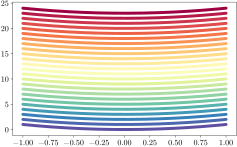

In [183]:
gen_Kcolors = col.get_linear_colors('Spectral_r',len(K)+20) 
x = np.linspace(-1,1,1000)
for i,c in enumerate(gen_Kcolors):
    plt.plot(x,x*x+i, color=c, lw=3)

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


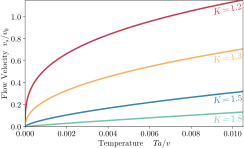

In [193]:
path_eff = [path_effects.withSimplePatchShadow(offset=(0.06, -0.06), shadow_rgbFace='k', alpha=1.0)]
from matplotlib import ticker
Kcolors = [gen_Kcolors[-3],gen_Kcolors[-8],gen_Kcolors[2],gen_Kcolors[5]]


plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    factor = [0.935,0.90,0.835,0.71,0.95,0.92]
    angle = [12,9,5,3,15,14]
    
    for i,cK in enumerate(K):
        ax.plot(T,vsov0[Klab(cK)],color=Kcolors[i], lw=1.5, label=f'$K={cK:2.1f}$')
        #ax.plot(data[str(cK)][:,0],data[str(cK)][:,1],color=Kcolors[2*i], lw=1)
        ax.text(0.01048,factor[i]*vsov0[Klab(cK)][-5],f'$K={cK}$', ha='right',va='top', color=Kcolors[i],
                              fontsize=9, rotation=angle[i])
    
    ax.set_xlim(0,0.0105);
    ax.set_ylim(0,1.15)
    
    ax.set_xlabel(r'Temperature   $\;T a / v$')
    ax.set_ylabel(r'Flow Velocity $\;v_s/v_0$')
    #ax.legend()
    
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    plt.savefig('../figures/LL_transport.pdf')
    plt.savefig('../figures/LL_transport.svg')

## Estimate of Experimental Scales

The relevant velocity scale is: $v_0 = {k_B T_\lambda/2 \rho_0}$ and for the unperturbed nanpores we know:

$K \simeq 1.3$, $v = 42 \mathrm{Å K}$, $\rho_0 \simeq 0.25 \mathrm{Å}^{-1}$



In [2]:
K = 1.3
v = 42
a = 1./0.25

### Relevant Temperature and Velocity Scales

In [3]:
v/a # temperature scale

10.5

In [196]:
(k/ħ)*2.1/2/(0.25E10) # velocity scale

54.98654243333537

In [194]:
0.004*10*1000

40.0